In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
from tqdm import tqdm

from ssd_model import SSD300
from ssd_data import InputGenerator
from ssd_data import preprocess
from ssd_utils import PriorUtil
from ssd_metric import confusion_matrix, plot_confusion_matrix, accuracy, evaluate_results

%matplotlib inline
plt.rcParams['figure.figsize'] = [12]*2
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(edgeitems=100, suppress=True, linewidth=200)

In [2]:
from data_voc import GTUtility
gt_util = GTUtility('data/VOC2012test/')

model = SSD300(num_classes=gt_util.num_classes)
model.load_weights('ssd300_voc_weights_fixed.hdf5', by_name=True)

priors_util = PriorUtil(model)

In [3]:
#np.random.seed(1337)
#idxs = np.random.randint(0, gt_util.num_samples, 32)
idxs = np.arange(gt_util.num_samples)
img_h, img_w = model.image_size

data = []
inputs = []
images = []
for i in tqdm(idxs):
    img_path = os.path.join(gt_util.image_path, gt_util.image_names[i])
    img = cv2.imread(img_path)
    inputs.append(preprocess(img, model.image_size))
    img = cv2.resize(img, (img_w, img_h), cv2.INTER_LINEAR)
    img = img[:, :, (2,1,0)] # BGR to RGB
    img = img / 256.
    images.append(img)
    data.append(gt_util.data[i])
inputs = np.asarray(inputs)

preds = model.predict(inputs, batch_size=1, verbose=1)

results = [priors_util.decode(p) for p in preds]

encoded_gt = [priors_util.encode(d) for d in data]

100%|██████████| 5138/5138 [00:22<00:00, 233.04it/s]


5138/5138 [==============================] - 79s 15ms/step


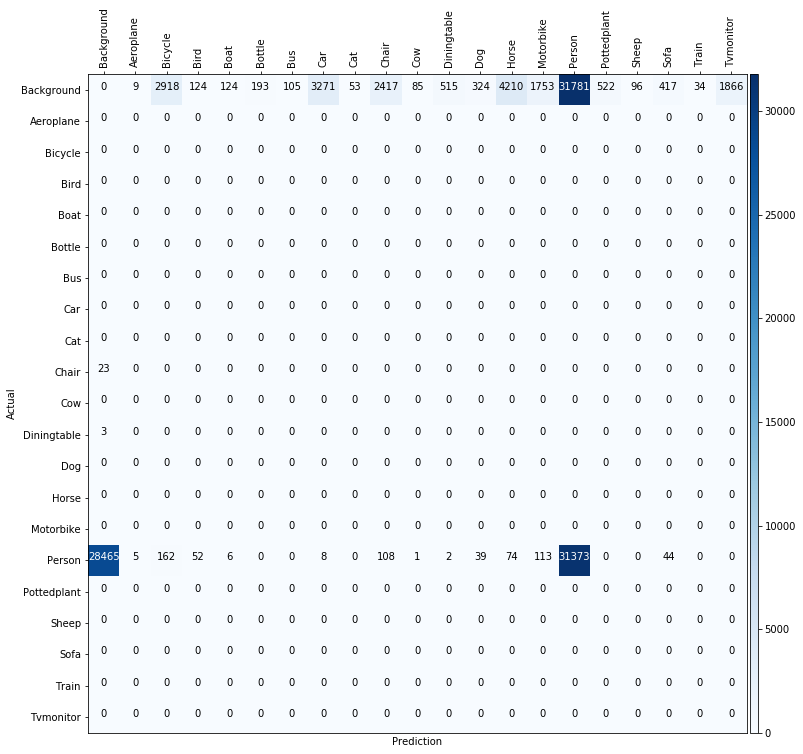

0.28189047127004807

In [4]:
y_true_all = []
y_pred_all = []

for i in range(len(data)):
    y_true = np.argmax(encoded_gt[i][:,4:], axis=1)
    y_pred = np.argmax(preds[i][:,4:], axis=1)
    #prior_object_idx = np.where(y_true)[0] # gt prior box contains object
    prior_object_idx = np.where(y_true+y_pred)[0] # gt or prediction prior box contains object
    y_true_all.extend(y_true[prior_object_idx])
    y_pred_all.extend(y_pred[prior_object_idx])
    
#y_pred_all = [ 17 for i in y_pred_all]
cm = confusion_matrix(y_true_all, y_pred_all, gt_util.num_classes)
plot_confusion_matrix(cm, gt_util.classes)
accuracy(y_true_all, y_pred_all)

Class                     TP       FP       FN     AP
 1 Aeroplane               0     4037        0    nan
 2 Bicycle                 0     6006        0    nan
 3 Bird                    0    10027        0    nan
 4 Boat                    0    11269        0    nan
 5 Bottle                  0    23640        0    nan
 6 Bus                     0     3782        0    nan
 7 Car                     0    20732        0    nan
 8 Cat                     0     1445        0    nan
 9 Chair                   1    32225        1  0.001
10 Cow                     0     2101        0    nan
11 Diningtable             0     8524        2  0.000
12 Dog                     0     3399        0    nan
13 Horse                   0     3895        0    nan
14 Motorbike               0     4933        0    nan
15 Person               6768    53262      558  0.701
16 Pottedplant             0    14058        0    nan
17 Sheep                   0     4346        0    nan
18 Sofa                    0

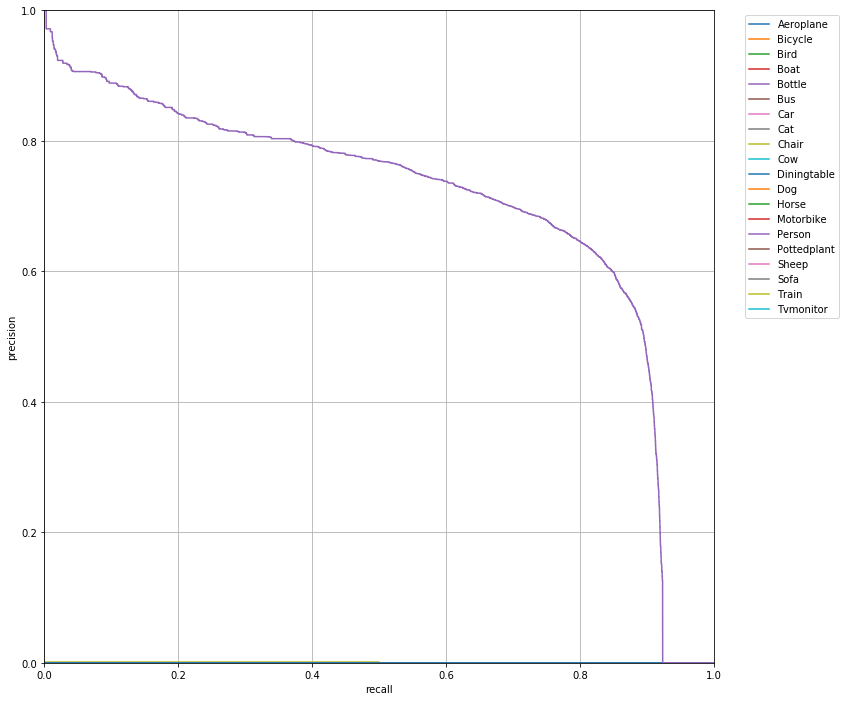

In [5]:
evaluate_results(data, results, gt_util, iou_thresh=0.5, max_dets=None)

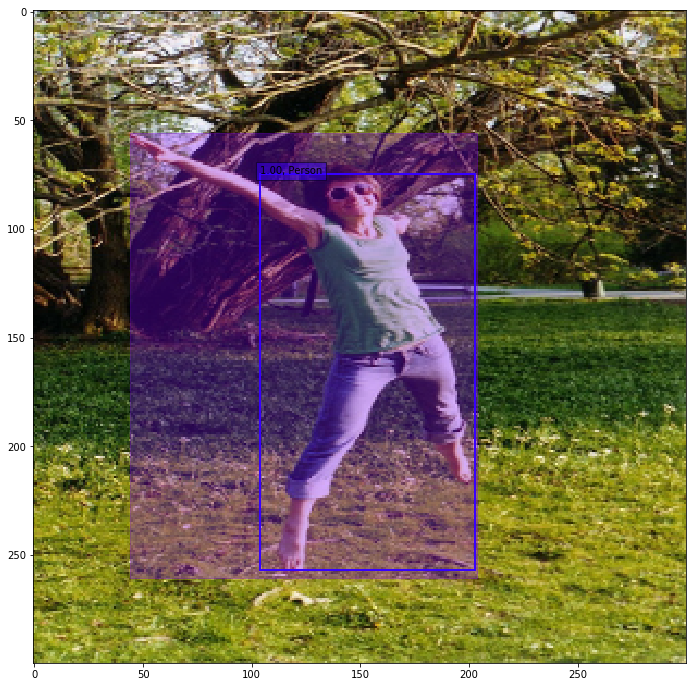

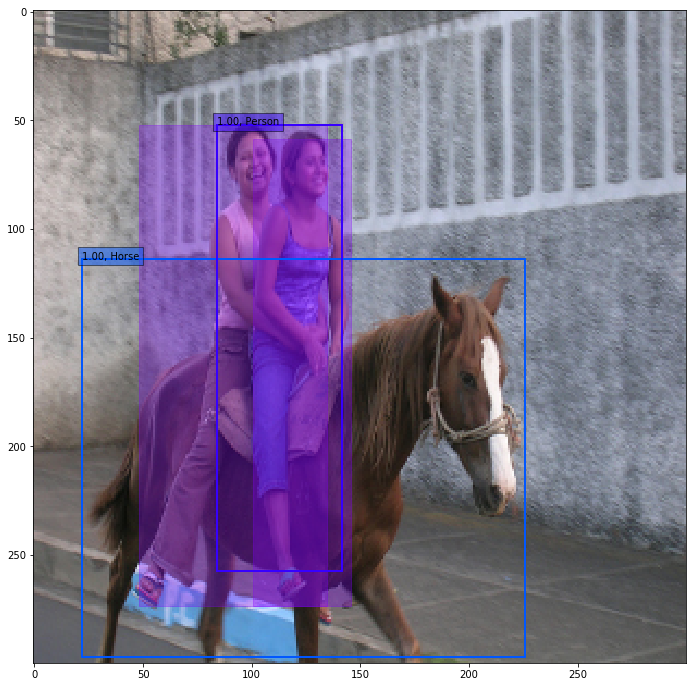

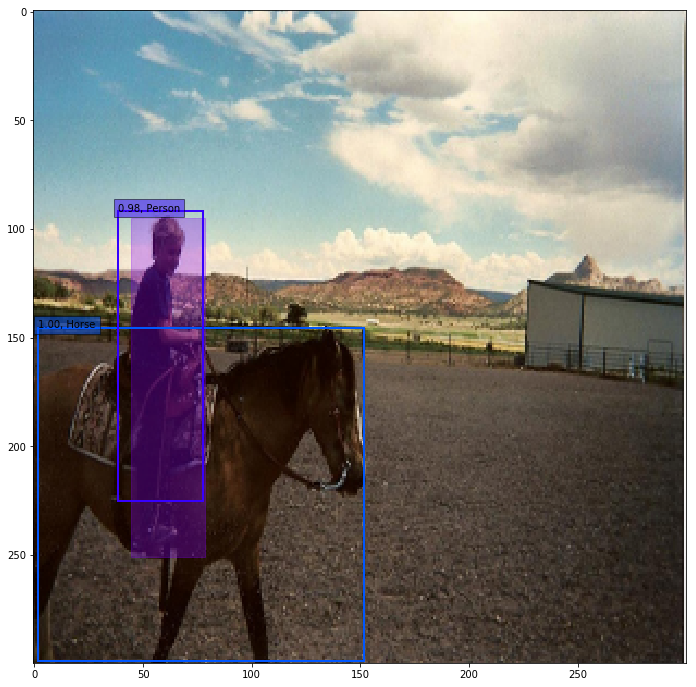

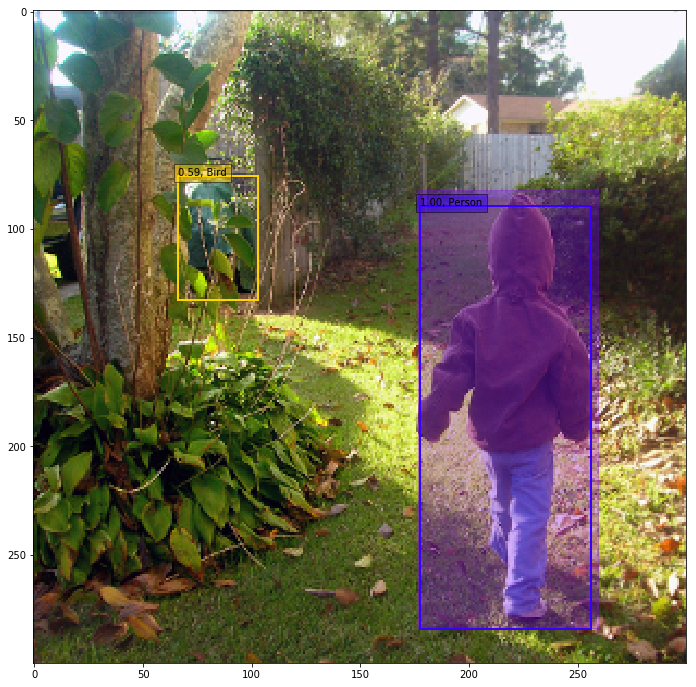

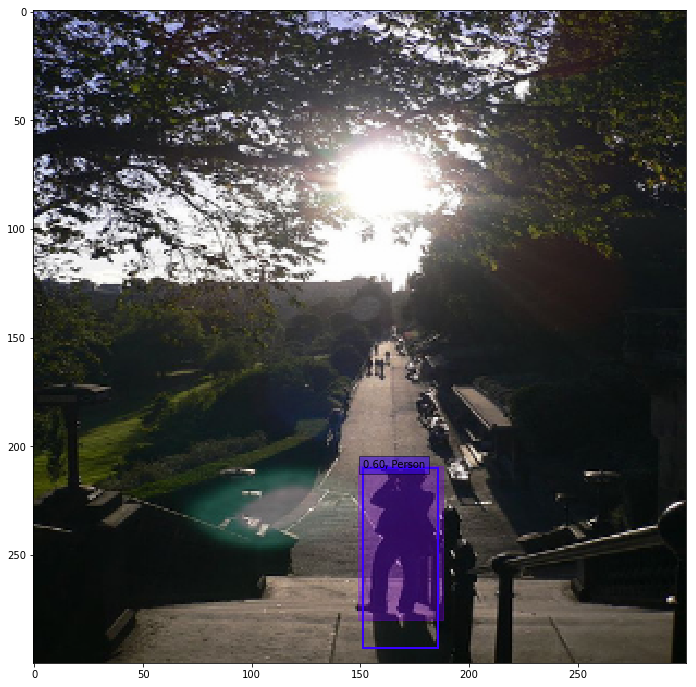

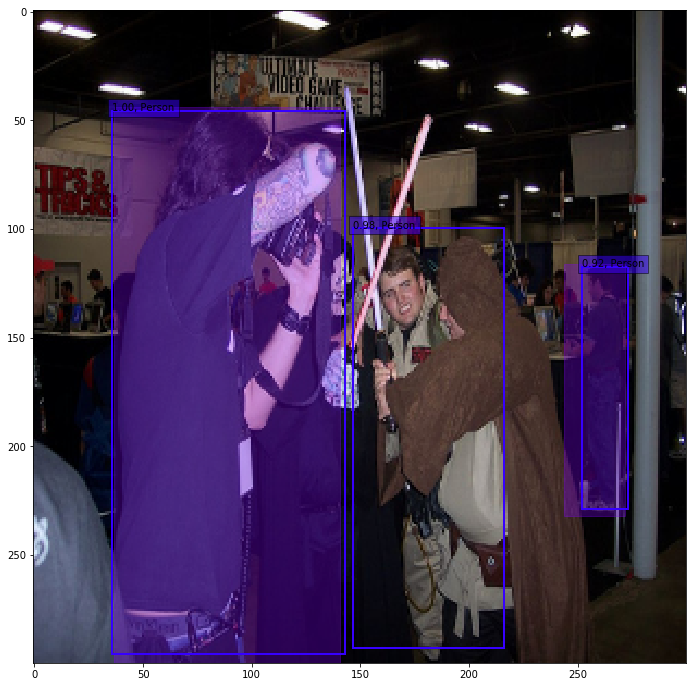

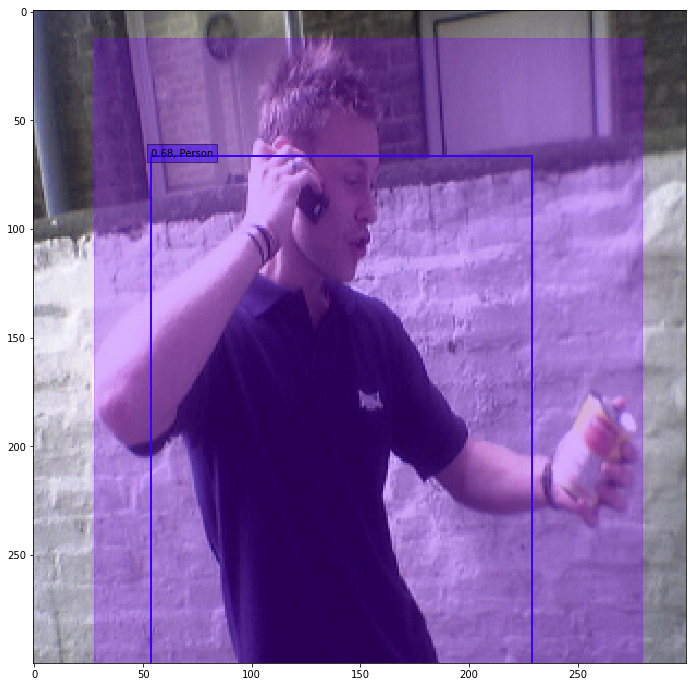

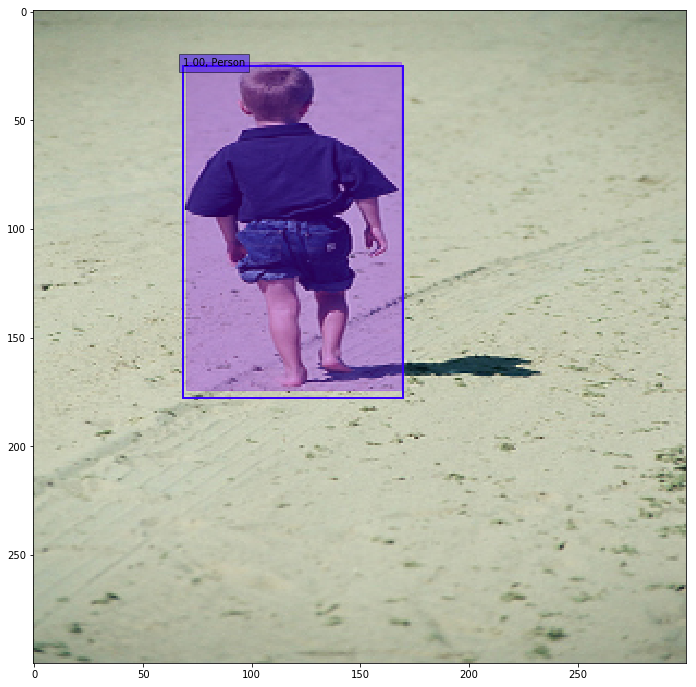

In [6]:
for i in np.random.randint(0, len(data), 8):
    plt.figure()
    plt.imshow(images[i])
    priors_util.plot_results(results=results[i], classes=gt_util.classes, gt_data=data[i], confidence_threshold=0.5)
    plt.show()